In [192]:
import os.path

import pandas as pd

bench = 'tnb101'
suffix = '_full' if bench != 'nb101' and 'macro' not in bench else '_first'
cfg = f'../zc_combine/configs/{bench}{suffix}.json'
dataset = 'cifar10' if bench != 'tnb101' else 'class_scene'

In [193]:
from zc_combine.utils.script_utils import create_cache_filename
from zc_combine.utils.script_utils import load_feature_proxy_dataset

version_key = 'paper'
cache_path = create_cache_filename('../scripts/cache_data/', cfg, None, version_key, True)

_, data, y = load_feature_proxy_dataset('../data', bench, dataset, cfg=cfg, use_all_proxies=True,
                                        cache_path=cache_path, version_key=version_key)

In [194]:
from zc_combine.fixes.operations import get_ops_edges_nb201, get_ops_edges_tnb101, get_ops_nb101

if bench == 'nb201':
    ops, edges = get_ops_edges_nb201()
    names = ('nor_conv_3x3', 'nor_conv_1x1')
elif bench == 'tnb101':    
    ops, edges = get_ops_edges_tnb101()
    names = ('nor_conv_3x3', 'nor_conv_1x1')
elif bench == 'nb101':
    ops = get_ops_nb101()
    names = ('conv3x3-bn-relu', 'conv1x1-bn-relu')
else:
    raise ValueError()

id1, id2 = ops.index(names[0]), ops.index(names[1])
print(names)
print(id1, id2)
data['#convs'] = data[f'op_count_{id1}'] + data[f'op_count_{id2}']

('nor_conv_3x3', 'nor_conv_1x1')
3 2


In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [196]:
import os

if not os.path.exists('figs'):
    os.mkdir('figs')    

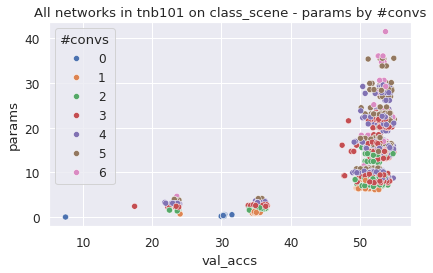

In [153]:
n_palette = len(data['#convs'].unique())

sns.set(font_scale=1.1)
prox = 'params'

plt.figure()
sns.scatterplot(data=data[data[prox] > 0], y=prox, x=y, hue=data['#convs'], palette=sns.color_palette()[:n_palette])

if bench == 'nb201':
    plt.xlim(50, 93)
elif bench == 'nb101':
    plt.xlim(63, 96)
elif bench == 'tnb101':
    #plt.xlim(10, 58)
    pass
    

plt.title(f'All networks in {bench} on {dataset} - {prox} by #convs')
plt.tight_layout()
plt.savefig(f'figs/{bench}_{prox}_nconvs.png')
plt.show()

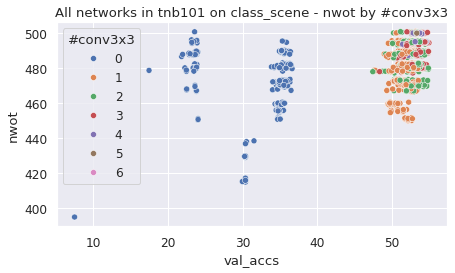

In [209]:
sns.set(font_scale=1.1)
prox = 'flops'

data['#conv3x3'] = data[f'op_count_{id1}']
n_palette = len(data['#conv3x3'].unique())

plt.figure(figsize=(6.5,4))
sns.scatterplot(data=data[data[prox] > 0], y=prox, x=y, hue=data['#conv3x3'], palette=sns.color_palette()[:n_palette])

if bench == 'nb201':
    plt.xlim(50, 93)
elif bench == 'nb101':
    plt.xlim(63, 96)
elif bench == 'tnb101':
    #plt.xlim(10, 58)
    pass

plt.title(f'All networks in {bench} on {dataset} - {prox} by #conv3x3')
plt.tight_layout()
plt.savefig(f'figs/{bench}_{prox}_n3x3.png')
plt.show()

In [200]:
proxies = [c for c in data.columns if 'op_' not in c and '(' not in c and c not in ['net', '#convs', '#conv3x3']]
print(proxies)

['fisher', 'flops', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain', 'snip', 'zen', 'epe_nas', 'synflow']


In [206]:
import scipy.stats
import pandas as pd


compute_tau = False
res_corrs = []

data['#conv3x3'] = data[f'op_count_{id1}']

key = '#conv3x3'

def get_corr(d):
    return {k: func(d[k], y[d.index])[0] for k in proxies}


for nc in sorted(data[key].unique()):    
    filtnets = data[data[key] == nc]
    if len(filtnets) < 2:
        continue
    
    func = scipy.stats.kendalltau if compute_tau else scipy.stats.spearmanr
    
    res = get_corr(filtnets)
    res = {key: nc, **res}
    res_corrs.append(res)
    
res_all = get_corr(data)
res_all = {key: 'all data', **res_all}
res_corrs.append(res_all)

df = pd.DataFrame(res_corrs)
df.T 

,0,1,2,3,4,5,6
#conv3x3,0,1,2,3,4,5,all data
fisher,-0.171577,-0.087389,-0.137912,-0.372016,-0.464055,-0.326471,0.368107
flops,0.221162,0.037685,-0.13358,-0.153105,-0.18554,-0.413089,0.650825
grad_norm,-0.122154,0.044973,-0.101573,-0.372756,-0.466397,-0.320588,0.382633
grasp,-0.12127,0.204487,0.063217,0.074269,0.251502,-0.176471,-0.033425
jacov,0.41636,0.51806,0.214296,0.054465,0.159161,0.238235,0.600625
l2_norm,0.322257,0.2754,0.108812,0.058386,-0.074043,-0.479412,0.410697
nwot,0.181356,0.275942,0.202712,0.16924,0.100264,-0.217647,0.449313
params,0.236236,-0.055171,-0.200268,-0.186103,-0.198358,-0.413089,0.638002
plain,0.260116,-0.214107,0.067401,0.145521,0.049465,0.182353,-0.046083


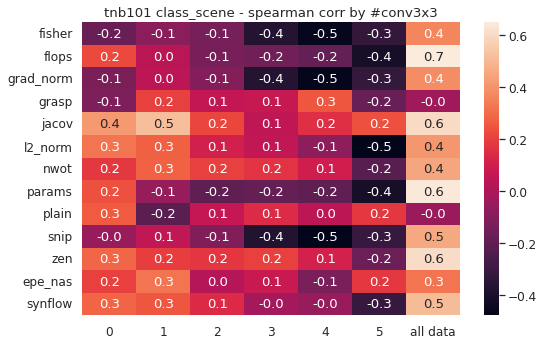

In [207]:
heatdf = df.T
heatdf.rename(columns=heatdf.iloc[0], inplace=True)
heatdf.drop(heatdf.index[0], inplace=True)

sns.set(font_scale=1.1)

plt.figure(figsize=(8, 5))
sns.heatmap(data=heatdf.astype(float), annot=True, fmt=".1f")
plt.title(f'{bench} {dataset} - spearman corr by {key}')
plt.tight_layout()
plt.savefig(f'figs/heat_{bench}_{key[1:]}.png')
plt.show()

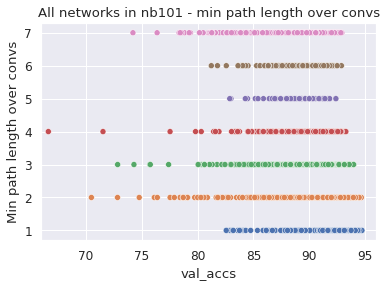

In [188]:
plt.figure()
sns.scatterplot(data=data, y='min_path_len_banned_(2)', x=y, hue='min_path_len_banned_(2)', legend=False, palette=sns.color_palette()[:7])
plt.xlim(66, 96)
plt.title(f'All networks in {bench} - min path length over convs')
plt.ylabel('Min path length over convs')
plt.savefig(f'figs/min_path_{bench}.png')
plt.show()

In [33]:
data.columns

Index(['op_count_0', 'op_count_1', 'op_count_2', 'op_count_3', 'op_count_4',
       'min_path_len_banned_()', 'min_path_len_banned_(2)',
       'min_path_len_banned_(3)', 'min_path_len_banned_(4)',
       'min_path_len_banned_(2, 3)', 'min_path_len_banned_(2, 4)',
       'min_path_len_banned_(3, 4)', 'max_op_on_path_allowed_(2)',
       'max_op_on_path_allowed_(3)', 'max_op_on_path_allowed_(4)',
       'max_op_on_path_allowed_(2, 3)', 'max_op_on_path_allowed_(2, 4)',
       'max_op_on_path_allowed_(3, 4)', 'max_op_on_path_allowed_(2, 3, 4)',
       'node_degree_allowed_(2)_in_degree',
       'node_degree_allowed_(2)_out_degree', 'node_degree_allowed_(2)_avg_in',
       'node_degree_allowed_(2)_avg_out', 'node_degree_allowed_(2)_max_out',
       'node_degree_allowed_(2)_max_in', 'node_degree_allowed_(3)_in_degree',
       'node_degree_allowed_(3)_out_degree', 'node_degree_allowed_(3)_avg_in',
       'node_degree_allowed_(3)_avg_out', 'node_degree_allowed_(3)_max_out',
       'node_degre